# Text Classification 

## Data Cleaning & Text-Preprocessing 

In [26]:
import pandas as pd 
import nltk 
from nltk.corpus import stopwords
import regex as re
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline
import seaborn as sns

In [27]:
frame = pd.read_csv('model-data.csv')

In [28]:
frame.head()

,content,domain
0,TEL AVIV – An Israeli start-up claims to have ...,breitbart
1,Three out of four college-educated Democrats s...,breitbart
2,Joel Fox of California’s “Fox & Hounds” politi...,breitbart
3,The Times of Israel reports: US President Bara...,breitbart
4,Chief social justice warrior and head coach fo...,breitbart


In [29]:
#Credit to Susan Li on Towards Data Science blog post

symbols_1 = re.compile('[/(){}\[\]\|@,;]') 
symbols_2 = re.compile('[^0-9a-z #+_]')
stopwords_set = set(stopwords.words('english'))



def preprocess(text):
    """ Takes in a string and returns cleaned string"""
    text = text.lower()
    text = symbols_1.sub(' ', text)
    text = symbols_2.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stopwords_set)
    return text 

In [30]:
#Test preprocessing step:

preprocess(frame['content'][5])

'californias democratic party midst mainstream media begun call civil war gov jerry brown unlikely peacemaker'

In [31]:
# How many total words do we have? 
frame['content'].apply(lambda x: len(x.split(' '))).sum()

13109148

### Question: Does breitbart or nytimes articles, on average, contain more words? Would this bias our analysis if we use CountVectorizer?

In [32]:
# First, let's apply the pre-processings step to our articles
frame['content'] = frame['content'].apply(preprocess)
frame.head()

,content,domain
0,tel aviv israeli startup claims developed prog...,breitbart
1,three four collegeeducated democrats seem beli...,breitbart
2,joel fox californias fox hounds political blog...,breitbart
3,times israel reports us president barack obama...,breitbart
4,chief social justice warrior head coach san an...,breitbart


In [33]:
# now let's calculate the average number of words per outlet aricle
def get_length(text):
    words = text.split(' ')
    return len(words)

tester = frame.copy()
tester['num_words'] = tester['content'].apply(get_length)
tester.groupby('domain').mean()

,num_words
domain,
breitbart,280.696167
nytimes,360.988500


#### Looks like nyt articles on average have more words than breitbart articles. This is good to know for future analysis. 

### Last step before modelling: Getting the data in the proper format. 

In [34]:
encodings = [1 if text == 'breitbart' else 0 for text in frame['domain']]
data = frame.drop(columns = 'domain')
data['label'] = encodings

In [35]:
data.head()

,content,label
0,tel aviv israeli startup claims developed prog...,1
1,three four collegeeducated democrats seem beli...,1
2,joel fox californias fox hounds political blog...,1
3,times israel reports us president barack obama...,1
4,chief social justice warrior head coach san an...,1


In [36]:
from sklearn.model_selection import train_test_split

X = data['content'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [37]:
# We will use the tf-idf vectorizer to encode our text as numerical vectors 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words = 'english', max_features = tester.groupby('domain').max()['num_words']['nytimes'])
vectorizer.fit(list(frame['content'].values))
X_train_cv = vectorizer.transform(X_train)
X_test_cv = vectorizer.transform(X_test)

In [38]:
# What are the dimensions of data matrix X_train and X_test? 
print(X_train_cv.shape)
print(X_test_cv.shape)

(18000, 11589)
(6000, 11589)


## Modelling 

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

### Model #1: Naive Bayes 

In [40]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB().fit(X_train_cv, y_train)
y_pred = nb_classifier.predict(X_test_cv)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=['breitbart', 'nytimes']))

accuracy 0.914
             precision    recall  f1-score   support

  breitbart       0.91      0.92      0.91      3010
    nytimes       0.91      0.91      0.91      2990

avg / total       0.91      0.91      0.91      6000



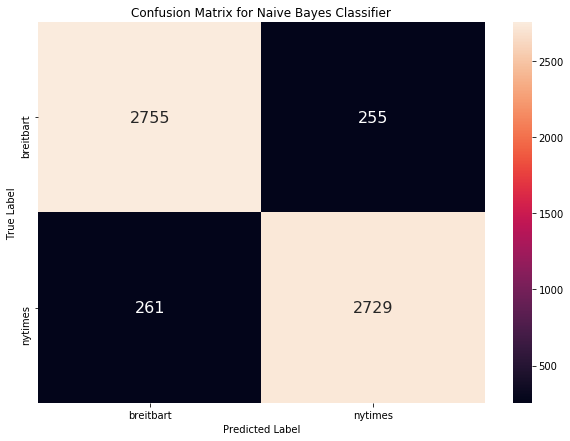

In [41]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in ['breitbart', 'nytimes']],
                  columns = [i for i in ['breitbart', 'nytimes']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes Classifier');

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.975


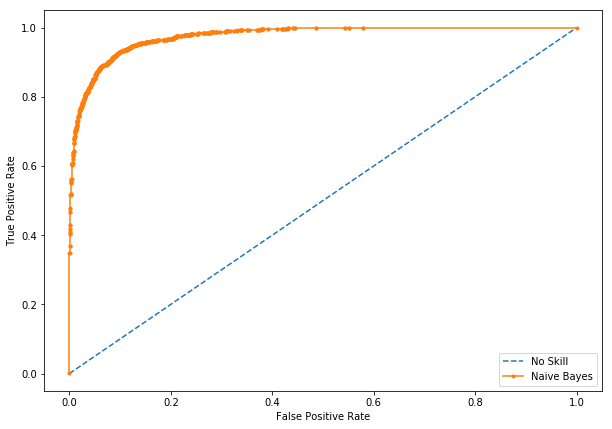

In [42]:
# Let's plot a ROC Curve 
plt.figure(figsize = (10, 7))

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_probs = nb_classifier.predict_proba(X_test_cv)
nb_probs = y_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
nb_auc = roc_auc_score(y_test, nb_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend();

### Model #2: Linear Kernel Support Vector Machine 

In [43]:
from sklearn.linear_model import SGDClassifier

linsvm_classifier = SGDClassifier(loss = 'hinge', penalty = 'l2', tol = None, max_iter = 1000)
linsvm_classifier.fit(X_train_cv, y_train)
y_pred = linsvm_classifier.predict(X_test_cv)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=['breitbart', 'nytimes']))

accuracy 0.9675
             precision    recall  f1-score   support

  breitbart       0.98      0.96      0.97      3010
    nytimes       0.96      0.98      0.97      2990

avg / total       0.97      0.97      0.97      6000



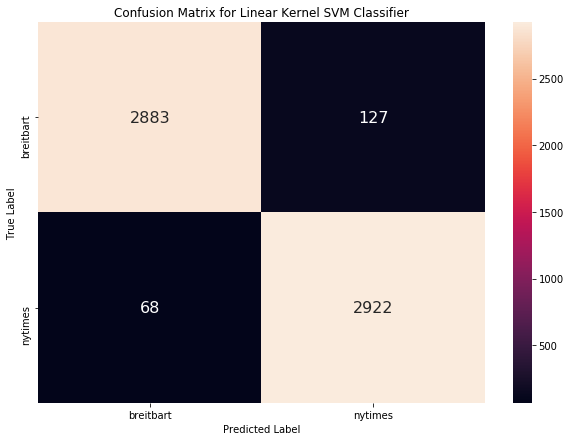

In [44]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in ['breitbart', 'nytimes']],
                  columns = [i for i in ['breitbart', 'nytimes']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Linear Kernel SVM Classifier');

### Model #3: Random Forest 

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_cv, y_train)
y_pred = rf_classifier.predict(X_test_cv)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=['breitbart', 'nytimes']))

accuracy 0.9476666666666667
             precision    recall  f1-score   support

  breitbart       0.96      0.93      0.95      3010
    nytimes       0.93      0.96      0.95      2990

avg / total       0.95      0.95      0.95      6000



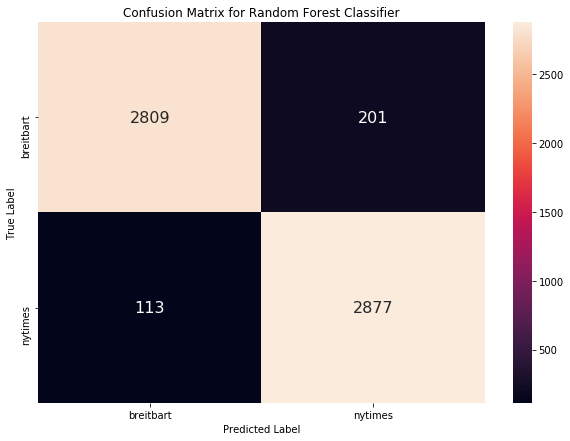

In [46]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in ['breitbart', 'nytimes']],
                  columns = [i for i in ['breitbart', 'nytimes']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier');

### Model #4: XGBoost

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

xg_classifier = GradientBoostingClassifier()
xg_classifier.fit(X_train_cv, y_train)
y_pred = xg_classifier.predict(X_test_cv)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=['breitbart', 'nytimes']))

accuracy 0.9448333333333333
             precision    recall  f1-score   support

  breitbart       0.98      0.90      0.94      3010
    nytimes       0.91      0.99      0.95      2990

avg / total       0.95      0.94      0.94      6000



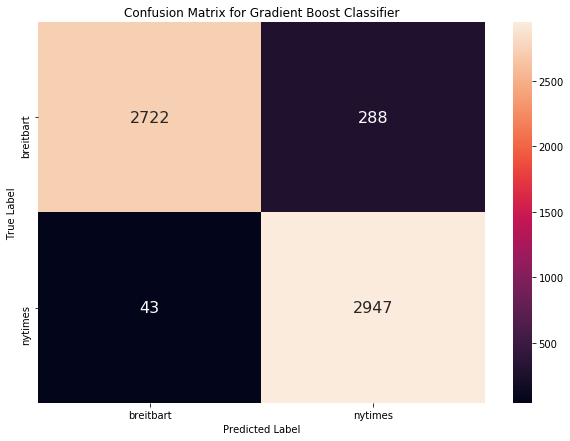

In [48]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in ['breitbart', 'nytimes']],
                  columns = [i for i in ['breitbart', 'nytimes']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Gradient Boost Classifier');

### Model #5: Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train_cv, y_train)
y_pred = logreg_classifier.predict(X_test_cv)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=['breitbart', 'nytimes']))

accuracy 0.9656666666666667
             precision    recall  f1-score   support

  breitbart       0.98      0.95      0.97      3010
    nytimes       0.95      0.98      0.97      2990

avg / total       0.97      0.97      0.97      6000



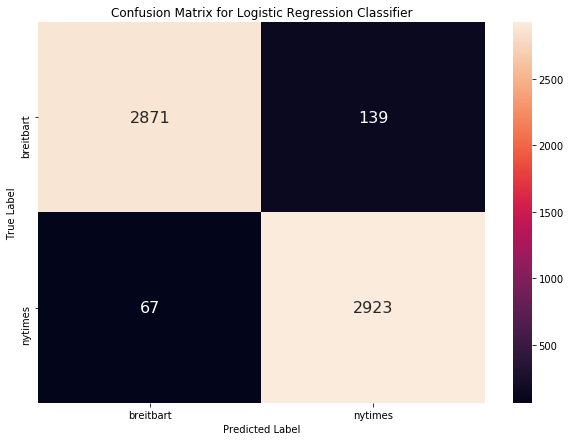

In [50]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in ['breitbart', 'nytimes']],
                  columns = [i for i in ['breitbart', 'nytimes']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Classifier');

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.995


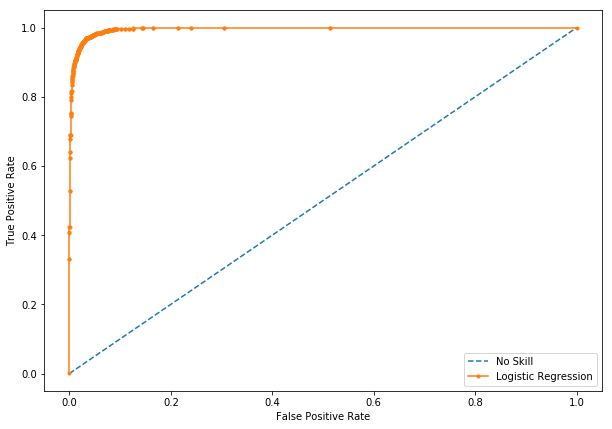

In [51]:
# Let's plot a ROC Curve 
plt.figure(figsize = (10, 7))

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_probs = logreg_classifier.predict_proba(X_test_cv)
logreg_probs = y_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
logreg_auc = roc_auc_score(y_test, logreg_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (logreg_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend();

### The top models in decreasing order were: Linear Kernel SVM, Logistic Regression, Random Forest, XGBoost, Naive Bayes